In [1]:
# WRITTEN BY CHRISTOPHER STONELL 2017
# GENERATES ACHS INDICATORS AND CONTROL CHARTS FOR PACU INDICATORS
# PLEASE ACKNOWEDGE THE SOURCE IF YOU CHOOSE TO USE THIS CODE.

# clear workspace
rm(list=ls())
# Load  or install required libraries
## First specify the packages
packages = c("gridExtra", "devtools", "qcc", "formattable", "htmltools", "webshot", "plyr", "knitr", "ggplot2", "digest")
## Now load or install & load
package.check <- lapply(
  packages,
  FUN = function(x) {
    if (!require(x, character.only = TRUE)) {
      install.packages(x, dependencies = TRUE)
      library(x, character.only = TRUE)
    }
  }
)

Loading required package: gridExtra
Loading required package: devtools
Loading required package: usethis
Loading required package: qcc
Package 'qcc' version 2.7
Type 'citation("qcc")' for citing this R package in publications.
Loading required package: formattable
Loading required package: htmltools
Loading required package: webshot
Loading required package: plyr
Loading required package: knitr
Loading required package: ggplot2
Registered S3 methods overwritten by 'tibble':
  method     from  
  format.tbl pillar
  print.tbl  pillar
Loading required package: digest


In [2]:
# Set directories
anaes.data.directory <- "~/Downloads/Anaesthetic"
# functions.directory  <- "~/MEGAsync/QA\ Data/R Functions"
pacu.data.directory  <- "~/Downloads/PACU"
output.directory     <- "~/Downloads/Output"

# Load required functions and routines
source("https://raw.githubusercontent.com/vxoli/R/master/Load%20%26%20Combine.R")
source("https://raw.githubusercontent.com/vxoli/R/master/export_formattable.R")
source("https://raw.githubusercontent.com/vxoli/R/master/anonymise.R")


In [3]:
# Retrieve MOT Data
setwd(anaes.data.directory)
# **consider amend function so pass path and fn reads files then returns to default path**
# ** also consider using zip files to store the data - perhaps one for mot and one for pac for each time period - then wouldn't need folder per data set but zip file per data set
mot.data <- data.frame(CombineAll())

# Drop Patient Name fields from data.frame
mot.data <- mot.data[, -which(names(mot.data) %in% c("Patient.First.Name", "Patient.Last.Name"))]

# Anonymise MRN with hash function
cols_to_anon <- c("MRN")
mot.data[,cols_to_anon] <- anonymise(mot.data,cols_to_anon)

# Modify dates from excel to work in R
# **could this be written as a fxn to be called with the format to convert and format to return**
mot.data$date = as.character(mot.data$Operation.Date)
mot.data$date = as.Date(mot.data$Operation.Date,format = "%d-%b-%Y")
mot.data$Month_Yr <- format(as.Date(mot.data$date), "%Y-%m")

# Correct $PACU.ICU.WARD variable (appears as pacu.icu.ward, icu.pacu.ward & pacu.ward.icu) - combined into pacu.icu.ward
mot.data$PACU.ICU.WARD[is.na(mot.data$PACU.ICU.WARD)] <- as.character(mot.data$ICU.PACU.WARD[is.na(mot.data$PACU.ICU.WARD)])
mot.data$PACU.ICU.WARD[is.na(mot.data$PACU.ICU.WARD)] <- as.character(mot.data$PACU.WARD.ICU[is.na(mot.data$PACU.ICU.WARD)])
mot.data <- mot.data[, -which(names(mot.data) %in% c("ICU.PACU.WARD", "PACU.WARD.ICU"))]


# Correct .PACU.ICU.WARD variable (appears as pacu.icu.ward & icu.pacu.ward - combined into pacu.icu.ward)
mot.data$PACU.ICU.WARD <- replace(mot.data$PACU.ICU.WARD, (mot.data$PACU.ICU.WARD == "HOME" | mot.data$PACU.ICU.WARD == "WARD"), "PACU")
monthlycases <- table(mot.data$Month_Yr, mot.data$PACU.ICU.WARD)[,c("ICU","PACU")]

# Clean up names in data
# Correct some duplicate names and remove suffex - Anaes Consultant from some
levels(mot.data$Anaes.1.Name) <- c(levels(mot.data$Anaes.1.Name), "COLLARD,Caroline", "SLYKERMAN,Julia", "HUANG,Dennis", "SINGH,Raman")
mot.data$Anaes.1.Name[mot.data$Anaes.1.Name == "COLLARD,Caroline - Anaes Cons"] <- "COLLARD,Caroline"
mot.data$Anaes.1.Name[mot.data$Anaes.1.Name == "SLYKERMAN,Julia - Anaes Consultant"] <- "SLYKERMAN,Julia"
mot.data$Anaes.1.Name[mot.data$Anaes.1.Name == "HUANG,Dennis - Anaes Consultant"] <- "HUANG,Dennis"
mot.data$Anaes.1.Name[mot.data$Anaes.1.Name == "SINGH,Raman - Anaes Consultant"] <- "SINGH,Raman"


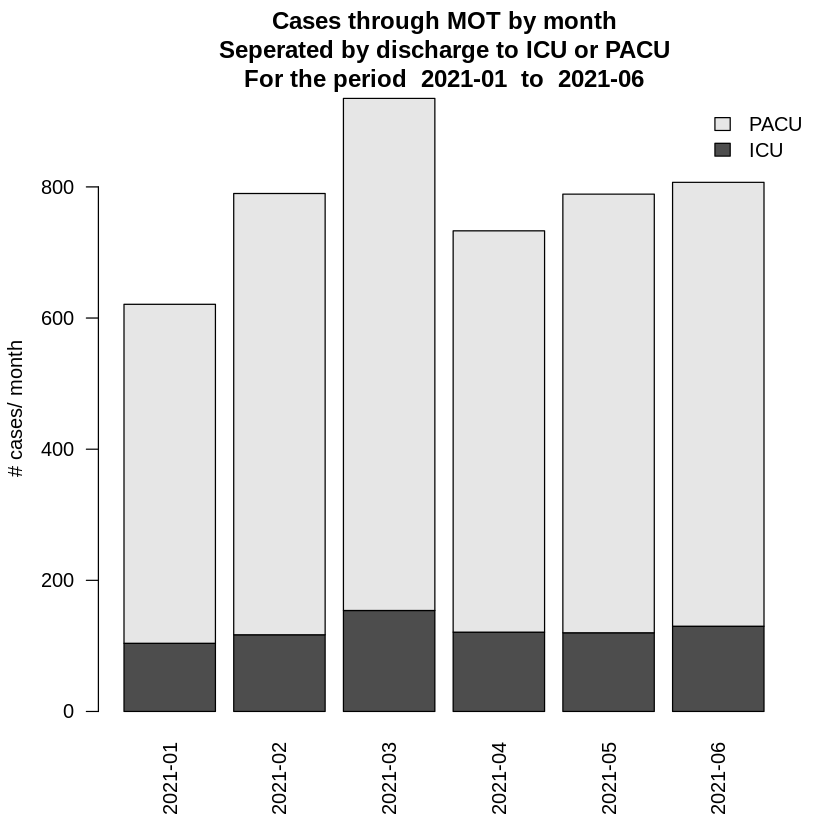

In [4]:
## Plot and save stacked barplot of MOT monthly activity seperated into ICU and PACU 
barplot(t(monthlycases), 
        ylab="# cases/ month", 
        las=2, 
        main=paste("Cases through MOT by month\nSeperated by discharge to ICU or PACU\nFor the period ",min(mot.data$Month_Yr)," to ",max(mot.data$Month_Yr)), 
        legend.text=c("ICU","PACU"),
        args.legend = list(
          x="topright",
          inset=c(-0.04,0),
          bty = "n"
        )
        )

In [5]:
table(mot.data$Month_Yr, mot.data$Specialty.Desc)[,order(colnames(table(mot.data$Month_Yr, mot.data$Specialty.Desc)))][,1:5]

         
          CARDIO-THORACIC SURGERY CARDIOLOGY GASTROENTEROLOGY GENERAL SURGERY
  2021-01                     127         26               11             173
  2021-02                     138         52                8             220
  2021-03                     160         58               14             245
  2021-04                     131         36               16             198
  2021-05                     138         54               12             203
  2021-06                     155         49                4             211
         
          ORTHOPAEDIC SURGERY
  2021-01                 169
  2021-02                 190
  2021-03                 243
  2021-04                 186
  2021-05                 204
  2021-06                 200

In [6]:
# Start analysis of PACU data
setwd(pacu.data.directory)
pacu.data <- data.frame(CombineAll())
# Drop patient names from pacu.data
pacu.data <- pacu.data[, -which(names(pacu.data) %in% c("Patient.First.Name", "Patient.Last.Name"))]
# Anonymise MRN with hash function
cols_to_anon <- c("MRN")
pacu.data[,cols_to_anon] <- anonymise(pacu.data,cols_to_anon)

# Normalise dates & accomodate the timestamp field
# pacu.data$date <- as.character(pacu.data$In.Recovery.At) - do i need this line???
pacu.data$date <- as.Date(pacu.data$In.Recovery.At,format = "%d/%m/%Y  %I:%M:%S %p")
pacu.data$Month_Yr <- format(as.Date(pacu.data$date), "%Y-%m")
pacu.data$Day_Month_Yr <- format(as.Date(pacu.data$date), "%Y-%m-%d")
pacu.data$Answer <- as.character(pacu.data$Answer)


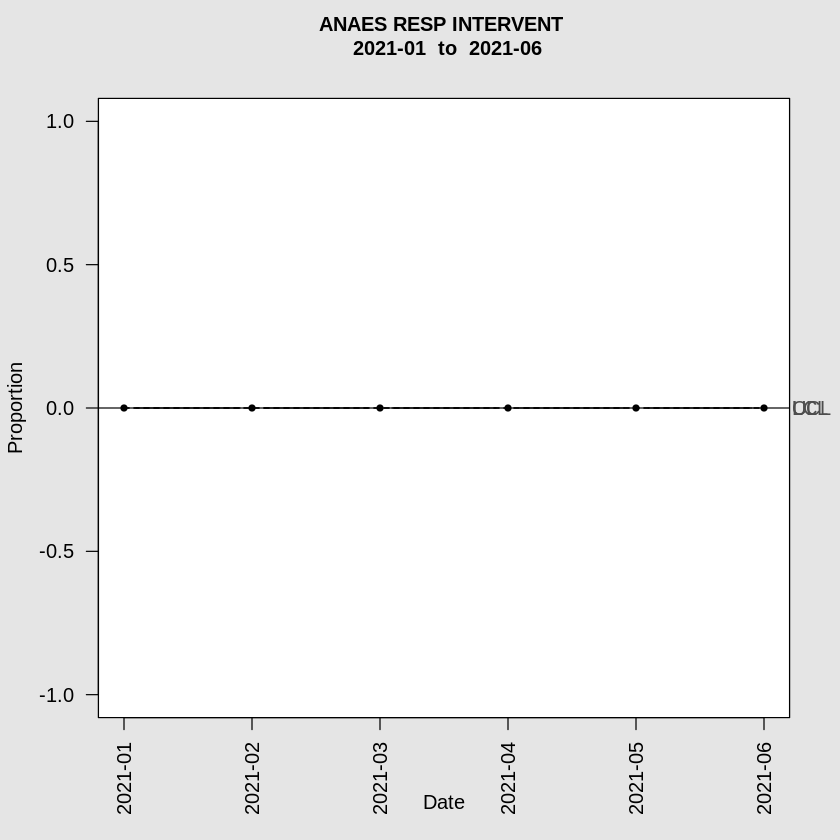

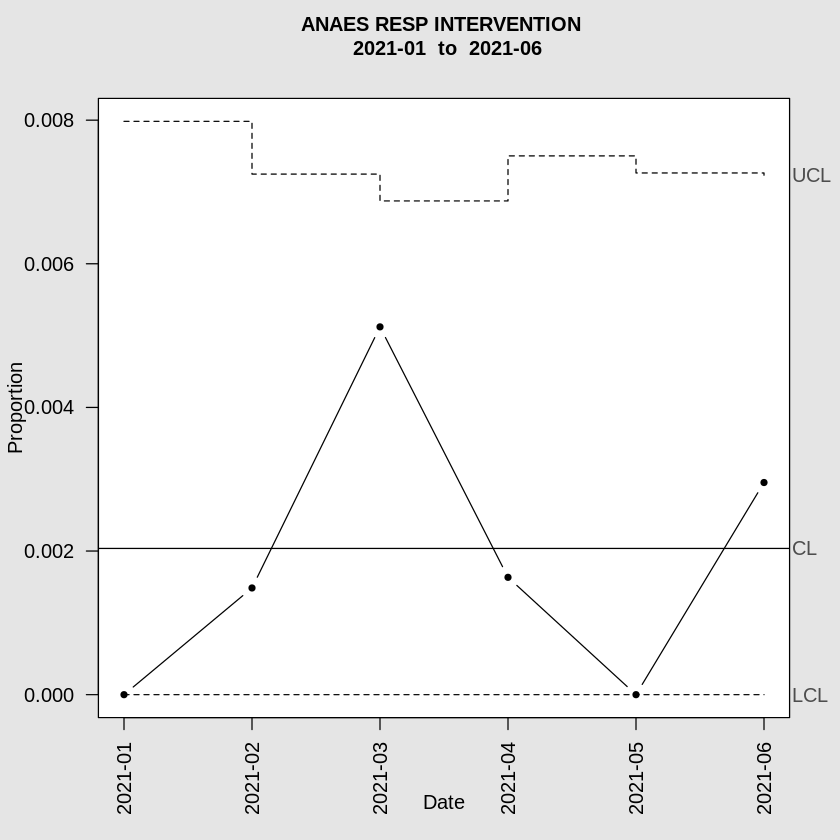

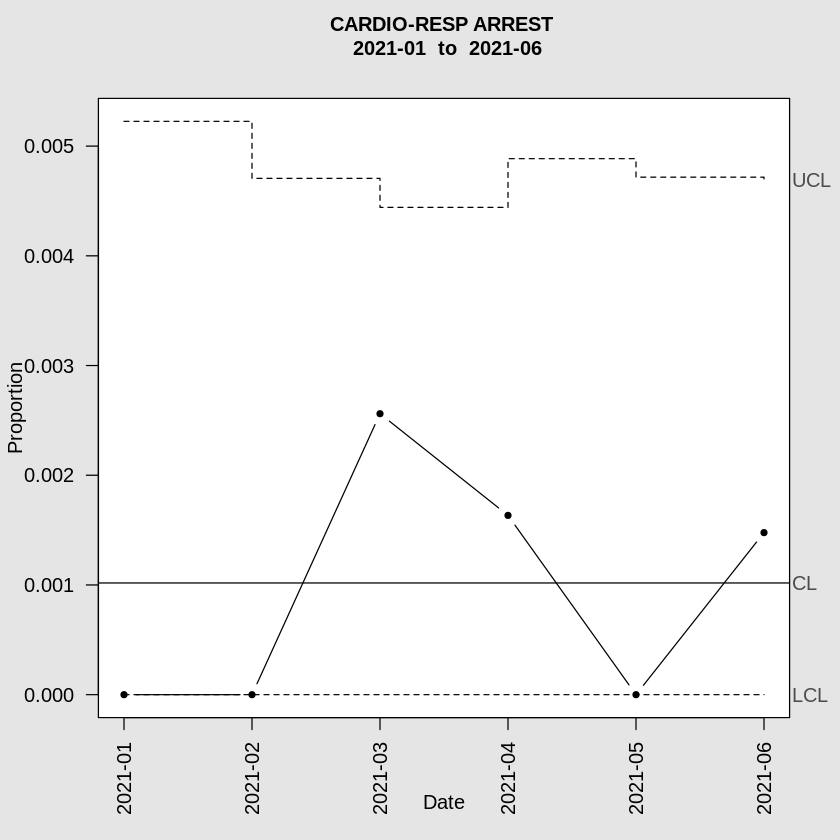

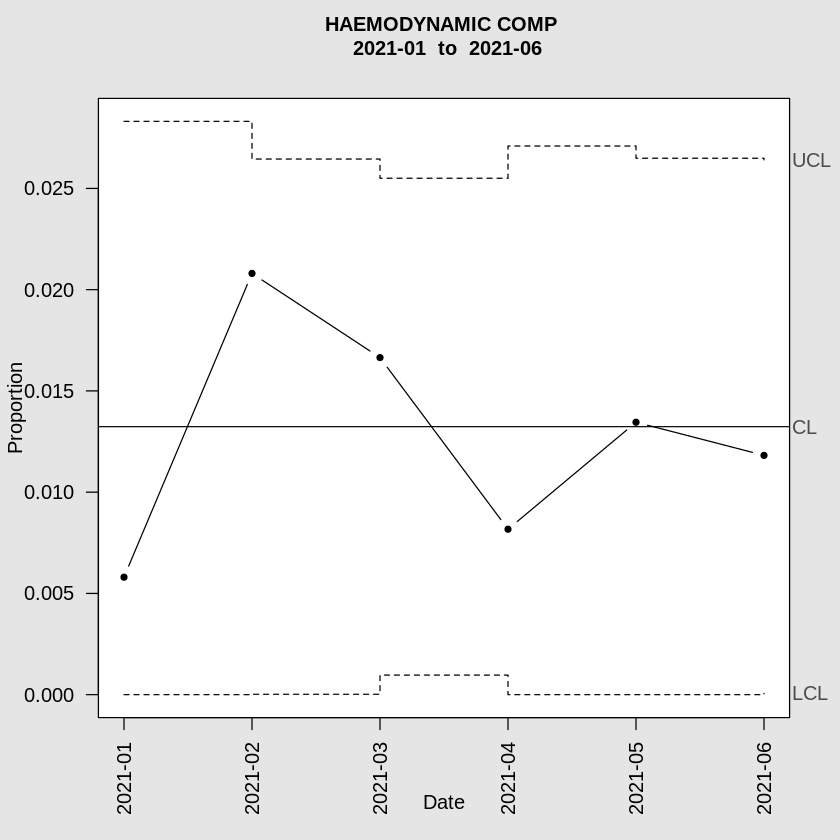

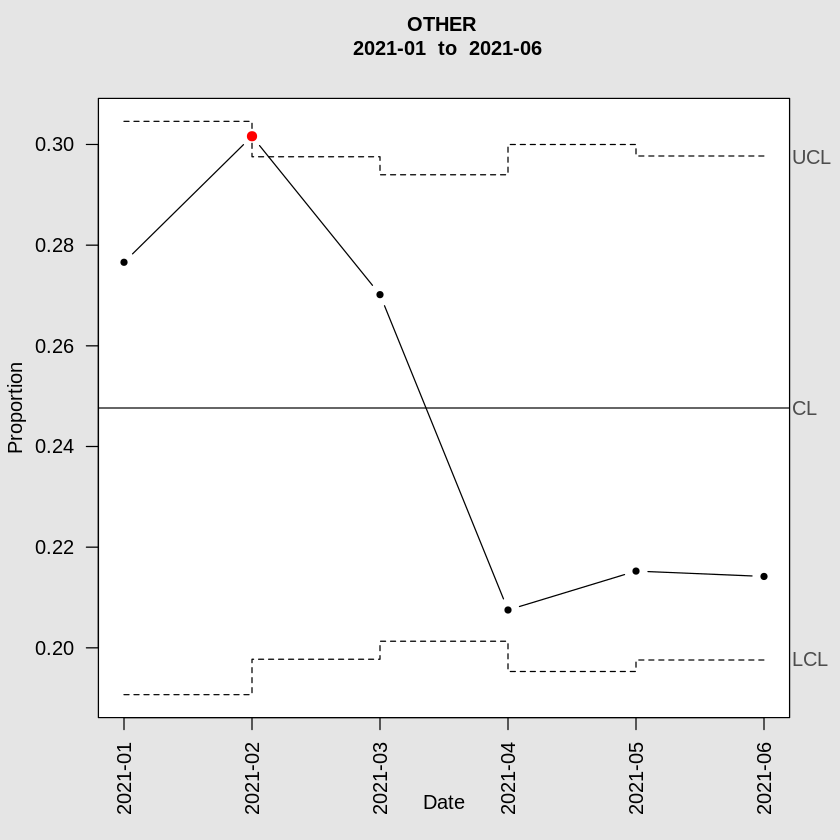

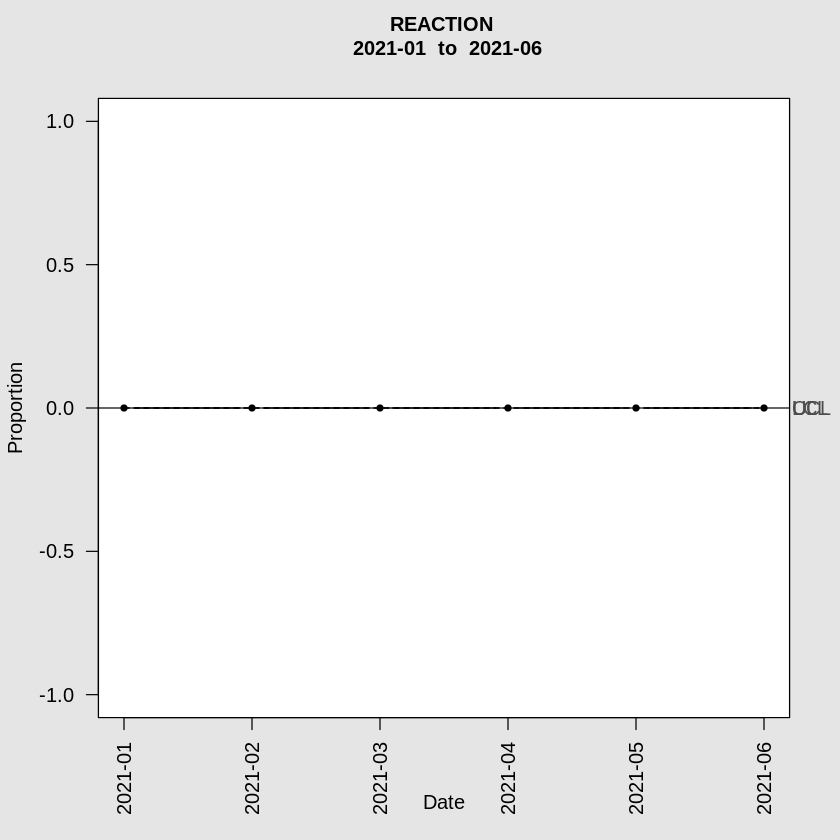

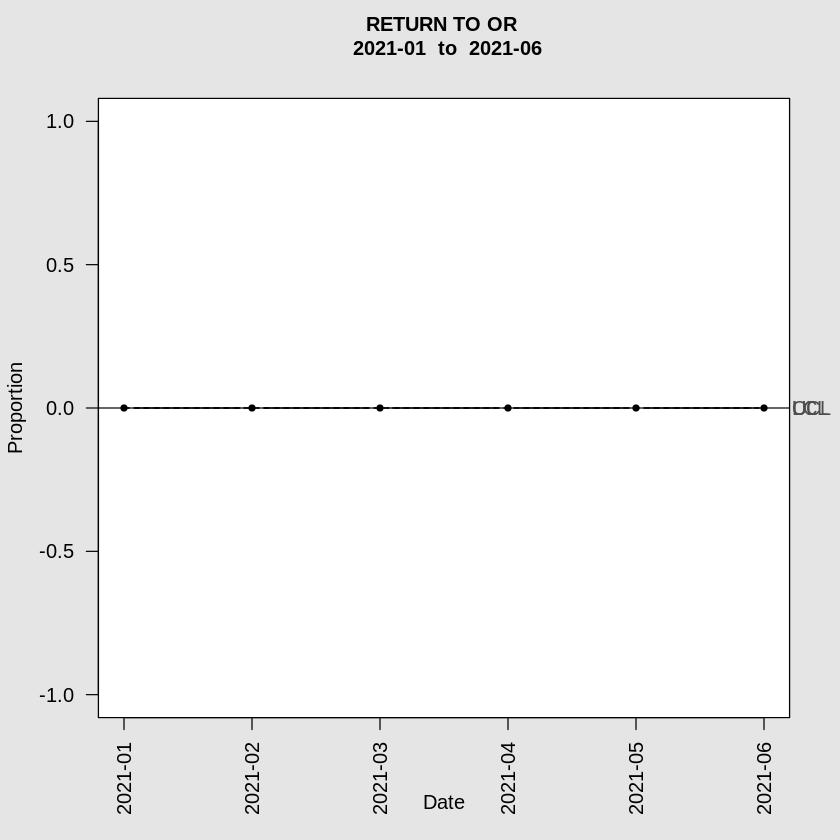

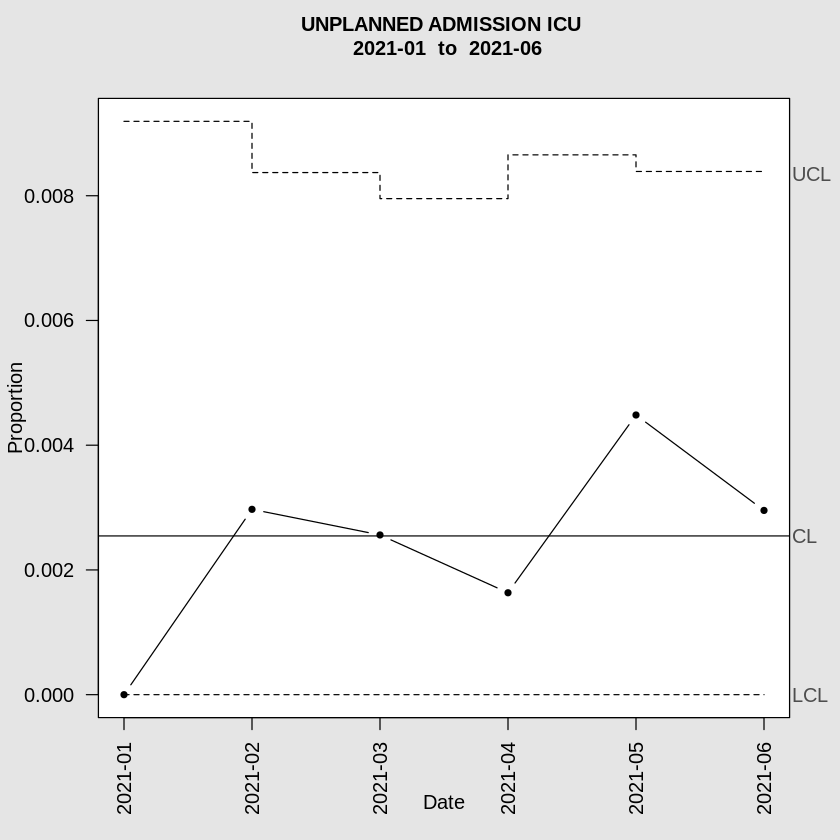

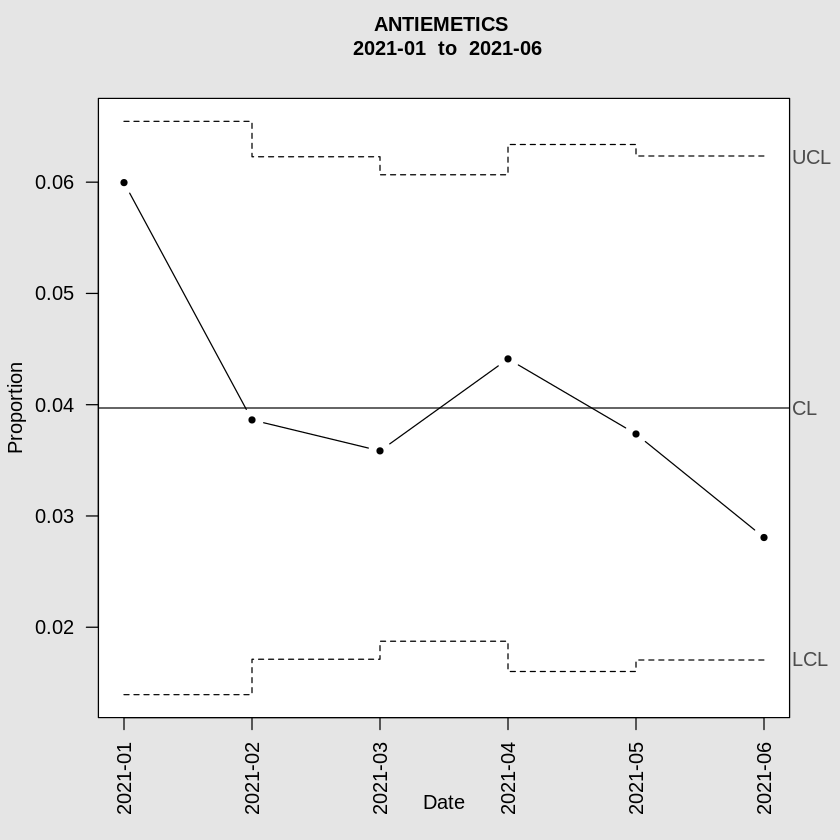

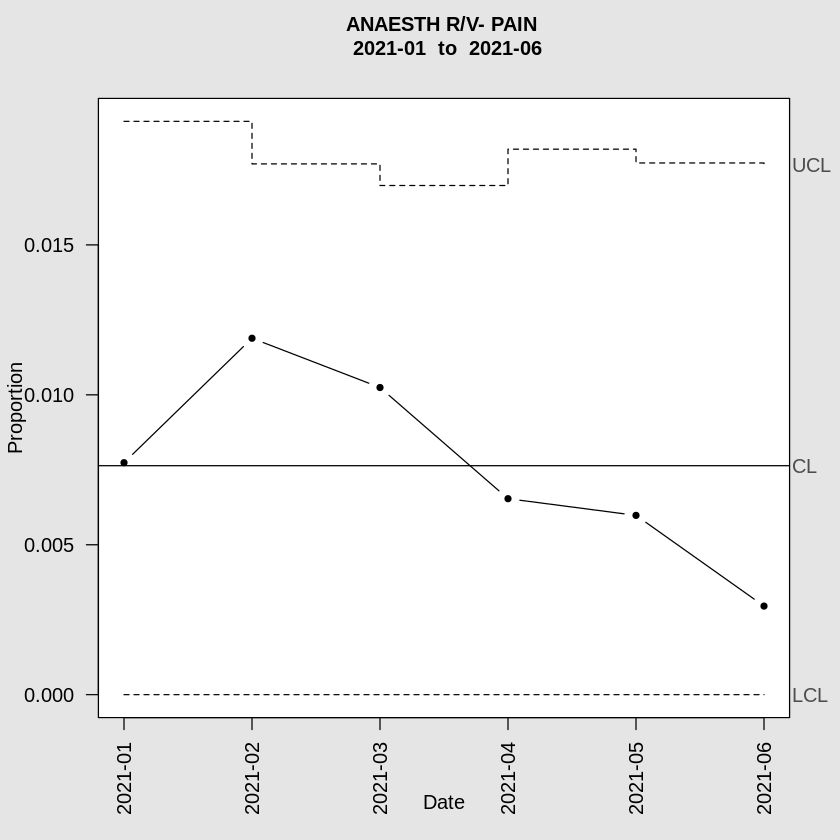

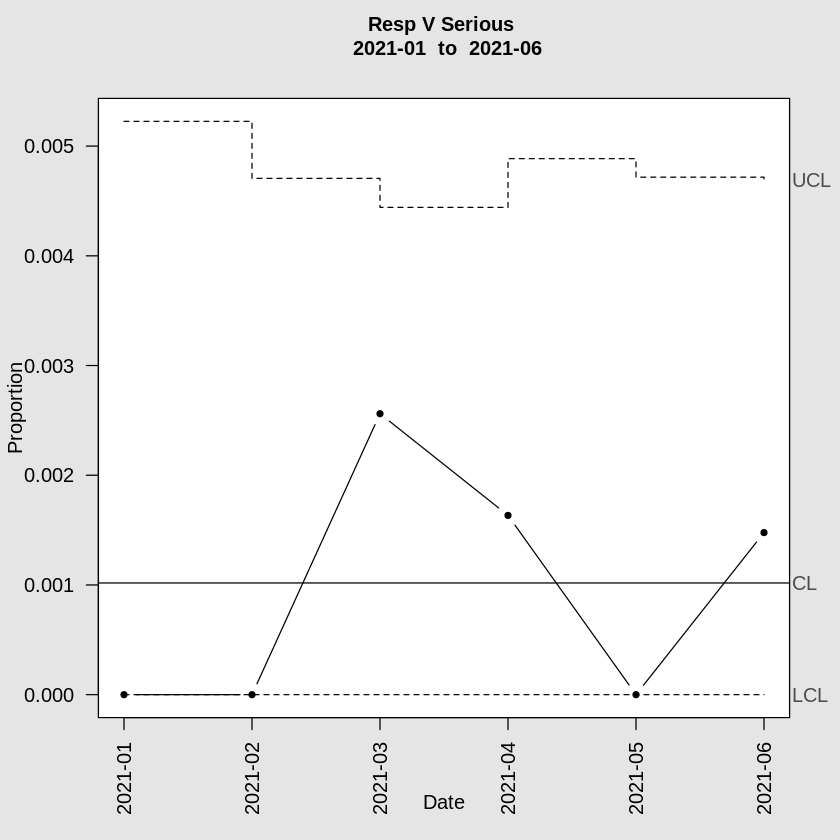

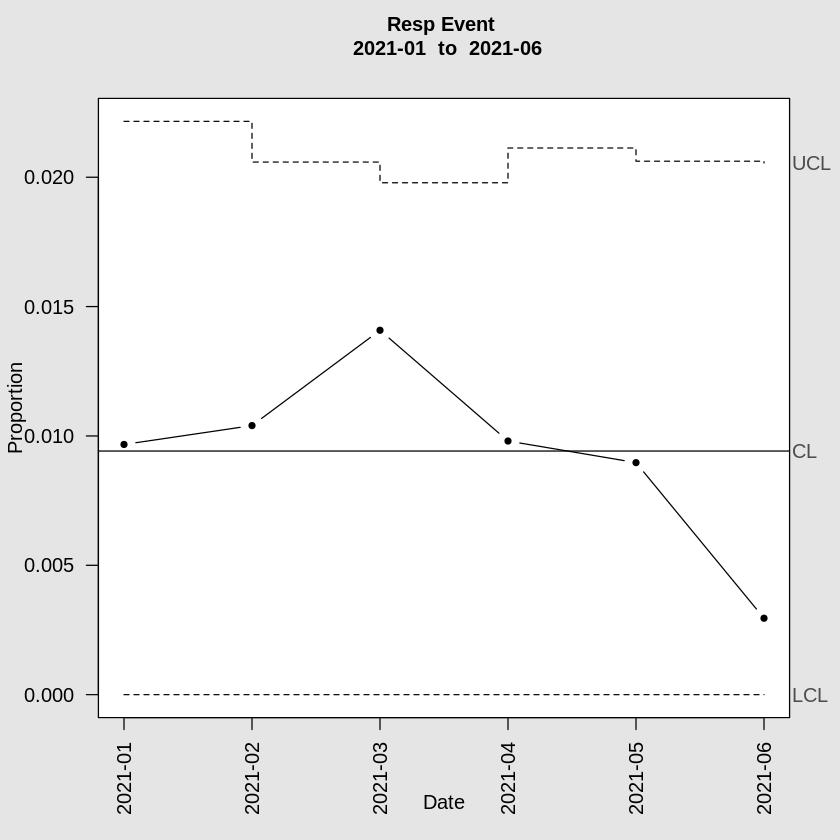

Indicator,Numerator,Denominator,Value
<fct>,<dbl>,<int>,<formttbl>
2.1 Presence of trained assistant,4675,4675,100.00%
3.1 Relief of respiratory distress in recovery,4,3929,0.10%
3.2 PONV treatment in PACU,0,3929,0.00%
3.3 Temp < 36C,21,3929,0.53%
3.4 Pain not responding to protocol,0,3929,0.00%
3.5 Unplanned stay > 2 hrs,0,3929,0.00%


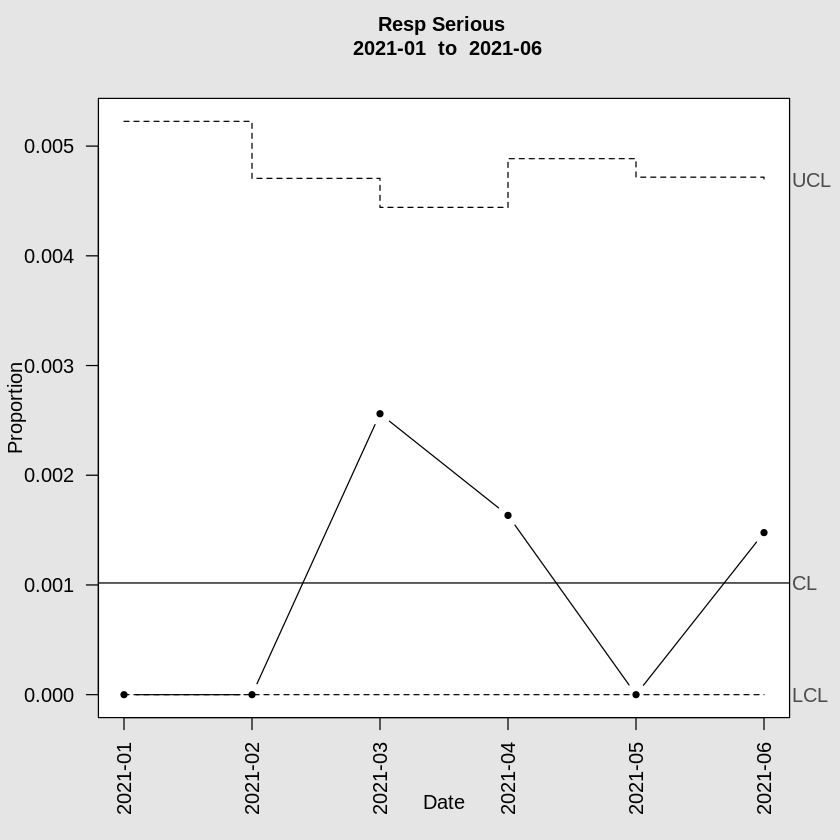

In [7]:
# Adverse events in ORMIS are:
events.descriptors <- c("ANAES RESP INTERVENT", "ANAES RESP INTERVENTION", "BLOOD FLUID LOSS", "CARDIO / RESP ARREST", "HAEMODYNAMIC COMP", "HYPOTHERMIA <36 DEG", "OTHER", "PERSISTENT PONV", "PROLONGED STAY >2 HR", "PROLONGED UNCONSC", "REACTION", "REINTUB/ VENTILATION", "RESP COMPLICATION", "RETURN TO OR", "UNPLANNED ADMISSION ICU", "ANTIEMETICS", "ANAESTH R/V- PAIN", "PAIN R/V ANAES CONS")

# Use PACU cases from MOT data for pacu total cases per month
events.adverse <- data.frame(matrix(NA, nrow=length(unique(mot.data$Month_Yr)), ncol=length(events.descriptors)+2))
# Data frame had date as 1st col, then total PACU cases per month as 1 column and event totals as other columns.
names(events.adverse) <- c("date","total.pacu.cases",events.descriptors)
# add dates from mot.data to dates column. 
events.adverse$date <- sort(unique(pacu.data$Month_Yr), decreasing=FALSE)
# add total cases per month through PACU to column
events.adverse$total.pacu.cases <- monthlycases[,"PACU"]


## !!! I might be able to tidy this section up with the aggregate function or tapply rather than
## generating tables and selecting columns!!!
## e.g. aggregate(mot.data$MRN,by=list(mot.data$Month_Yr,mot.data$Anaes.1.Name), FUN=length)


#First do frequency table by month
# enter event counts to each column - ensure dates match up
for (i in events.descriptors){
  t <- as.data.frame(table(pacu.data$Month_Yr, pacu.data$Answer == i))
  t <- subset(t, t["Var2"]==TRUE)
  events.adverse[,i] <- t["Freq"]
} # End for i loop
# Alternate method to count by date and event - may be quicker/ better - seems to not work correctly ??syntax
# events.adverse[,i] <- with(pacu.data, tapply(pacu.data$Answer==i, pacu.data$Month_Yr, FUN=function(x) length(unique(x))))
# If no adverse events in a category the column will remain filled with NA - convert these to zero for calculations
events.adverse[is.na(events.adverse)] <- 0

# Respiratory event = Anaes intervent + Cardio/ Resp Arrest + Reintub + Resp Complication
events.adverse$"Resp V Serious" <- events.adverse$"CARDIO / RESP ARREST" + events.adverse$"REINTUB/ VENTILATION"
events.descriptors <- c(events.descriptors, "Resp Event", "Resp Serious", "Resp V Serious")
events.adverse$"Resp Event" <- events.adverse$"ANAES RESP INTERVENT" + events.adverse$"CARDIO / RESP ARREST" + events.adverse$"REINTUB/ VENTILATION" + events.adverse$"RESP COMPLICATION"
# Serious Resp event = Anaes intervent + Cario Resp Arrest + Reintub
events.adverse$"Resp Serious" <- events.adverse$"ANAES RESP INTERVENT" + events.adverse$"CARDIO / RESP ARREST" + events.adverse$"REINTUB/ VENTILATION"
# V Serous Resp Event = Arrest + Reintub

# Change CARDIO / RESP ARREST as this label causes an error later when used for file nameing
names(events.adverse)[names(events.adverse)=="CARDIO / RESP ARREST"] <- "CARDIO-RESP ARREST"
events.descriptors <- names(events.adverse[2:length(events.adverse)])
# Update pacu.data$Answer with new event name
pacu.data$Answer[grep("CARDIO / RESP ARREST", pacu.data$Answer, ignore.case=TRUE)] <- as.character("CARDIO-RESP ARREST")
# Change REINTUB/ VENTILATION as this label causes an error later when used for file nameing
names(events.adverse)[names(events.adverse)=="REINTUB/ VENTILATION"] <- "REINTUBATION"
events.descriptors <- names(events.adverse[2:length(events.adverse)])
# Update pacu.data$Answer with new event name
pacu.data$Answer[grep("REINTUB/ VENTILATION", pacu.data$Answer, ignore.case=TRUE)] <- as.character("REINTUBATION")

# Unplanned ICU admission should be calculated from the mot data detecting dispatity between
# planned discharge ward and actual discharge ward

# Remove unnecessary columns for charting etc or use new vector with only columns needed for charting
# Update the event descriptors in the vector
events.infrequent.descriptors <- c(events.descriptors[4], events.descriptors[11], events.descriptors[13],events.descriptors[14]) #Cardiac Arrest, Reintubation, Return to OR, Unplanned ICU
events.to.skip <- c(events.descriptors[7], events.descriptors[9], events.descriptors[10], events.descriptors[19], events.infrequent.descriptors) # Other, Prolonged Unconc, Reaction, Resp V Serious

# Do plots for each event descriptor & write to pdf
events.to.chart <- events.descriptors[! events.descriptors %in% events.to.skip]
events.to.chart <- events.to.chart[2:length(events.to.chart)]
for (i in events.to.chart){
    qcc(data = events.adverse[i],
      type="p",
      sizes=events.adverse$total.pacu.cases,
      nsigmas=3,
      labels=events.adverse$date,
      axes.las=2,
      data.name = i, #c(i, min(mot.data$Month_Yr), "-", max(mot.data$Month_Yr)),
      add.stats=FALSE,
      xlab= "Date",
      ylab = "Proportion",
      title = paste(i, "\n", min(mot.data$Month_Yr), " to ", max(mot.data$Month_Yr))
      ) # Close qcc
  } # end for i

# Use qcc g-chart for plot of days between events
# use for return to or, cardiac arrest, reintubation, unplanned admiss icu - might need to consider larger data set so longer time span analysed
# Plot g-charts
for (i in events.infrequent.descriptors) {
  if (i %in% (events.infrequent.descriptors[2|3])) next
 t <- as.data.frame(table(pacu.data$Day_Month_Yr, pacu.data$Answer == i))
 t <- subset(t, t["Var2"]==TRUE)
 events.infrequent <- t["Freq"]
 noevents <- diff(which(c(1,events.infrequent[,1])>=1))-1

t <- subset(t, t$Freq>=1)
par(mfrow=c(1,1))
qcc(noevents,
    type="g",
    #nsigmas=3,
    conf=0.95,
    labels=t[,"Var1"],
    axes.las=2,
    add.stats=FALSE,
    xlab= "Date",
    ylab = "Days between",
    title = paste(i, "\n", min(mot.data$Month_Yr), " to ", max(mot.data$Month_Yr)),
    restore.par = FALSE #to allow adding lines etc to chart with par command
)# Close qcc
} # Close For i

# code for calculating days between infrequent events
# pacu.data[which(pacu.data$Answer==events.descriptors[2]),"Day_Month_Yr"]

# CALCULATE ACHS INDICATORS and TABLE:
# ACHS indicators are:
# 1.1 Pre-anesthetic consultation by anaesthetist
# 1.2 Smoking cessation advice in pre-anaesthetic consultation
# 2.1 Presence of trained assistant
# 2.2 Documentation complies with ANZCA PS6
# 2.3 Stop-before you block procedure
# 2.4 Prophlactic antiemetics administered to patients wit a history
# 3.1 Relief of respiratory distress in recovery (re-intub/ LMA/ ventilation)
# 3.2 PONV treatment in PACU
# 3.3 Temp < 36C
# 3.4 Pain not responding to protocol
# 3.5 Unplanned stay > 2 hrs
# 4.1 Unplanned admission to ICU
# 4.2 Documented handover MOT-PACU
# 4.3 Documented handover PACU-Ward
# 5.1 Pain scores recorded for surgical patients
# 5.2 Post-op epidurals reviewed by anaesthetist daily
#

ACHS.2.1 <- percent(length(mot.data[,"Tech.1.Name"])/length(mot.data[,"Anaes.1.Name"]))
ACHS.3.1 <- percent(sum(events.adverse$`Resp V Serious`) / sum(monthlycases[,"PACU"]),format="d")
ACHS.3.2 <- percent(sum(events.adverse$PONV) / sum(monthlycases[,"PACU"]),format="d")
ACHS.3.3 <- percent(sum(events.adverse$`HYPOTHERMIA <36 DEG`) / sum(monthlycases[,"PACU"]),format="d")
ACHS.3.4 <- percent(sum(events.adverse$`Pain Revew`) / sum(monthlycases[,"PACU"]),format="d")
ACHS.3.5 <- percent(sum(events.adverse$`PROLONGED STAY >2 HR`) / sum(monthlycases[,"PACU"]),format="d")

ACHS.table <- data.frame(
  Indicator = c("2.1 Presence of trained assistant",
                "3.1 Relief of respiratory distress in recovery",
                "3.2 PONV treatment in PACU",
                "3.3 Temp < 36C",
                "3.4 Pain not responding to protocol",
                "3.5 Unplanned stay > 2 hrs"
    ),
  Numerator = c(length(mot.data[,"Tech.1.Name"]), 
                sum(events.adverse$`Resp V Serious`),
                sum(events.adverse$PONV),
                sum(events.adverse$`HYPOTHERMIA <36 DEG`),
                sum(events.adverse$`Pain Revew`),
                sum(events.adverse$`PROLONGED STAY >2 HR`)),
  Denominator = c(length(mot.data[,"Anaes.1.Name"]),
                  sum(monthlycases[,"PACU"]),
                  sum(monthlycases[,"PACU"]),
                  sum(monthlycases[,"PACU"]),
                  sum(monthlycases[,"PACU"]),
                  sum(monthlycases[,"PACU"])),
  Value = c(ACHS.2.1, ACHS.3.1, ACHS.3.2, ACHS.3.3, ACHS.3.4, ACHS.3.5)
) # Close ACHS.table <- df

formattable(ACHS.table,align=c("l","r","r","r"))


Warning message:
“Removed 2030 row(s) containing missing values (geom_path).”Warning message:
“Removed 10 row(s) containing missing values (geom_path).”Warning message:
“Removed 2030 row(s) containing missing values (geom_path).”Warning message:
“Removed 27 row(s) containing missing values (geom_path).”Warning message:
“Removed 2 rows containing missing values (geom_point).”Warning message:
“Removed 1059 row(s) containing missing values (geom_path).”Warning message:
“Removed 99 row(s) containing missing values (geom_path).”Warning message:
“Removed 2030 row(s) containing missing values (geom_path).”Warning message:
“Removed 277 row(s) containing missing values (geom_path).”

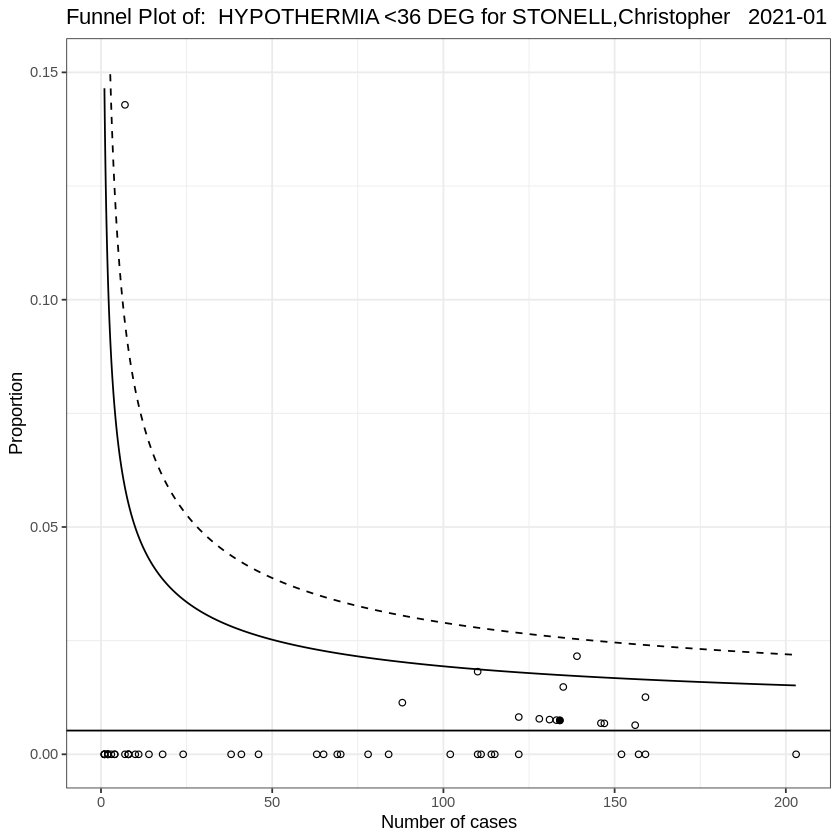

Warning message:
“Removed 2030 row(s) containing missing values (geom_path).”Warning message:
“Removed 14 row(s) containing missing values (geom_path).”Warning message:
“Removed 2030 row(s) containing missing values (geom_path).”Warning message:
“Removed 38 row(s) containing missing values (geom_path).”

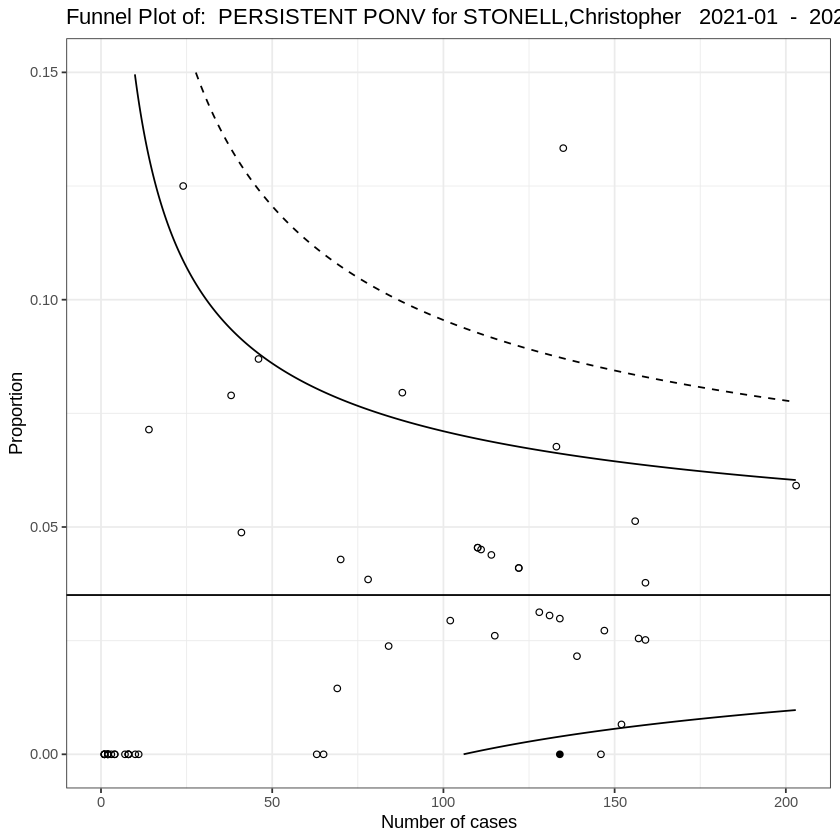

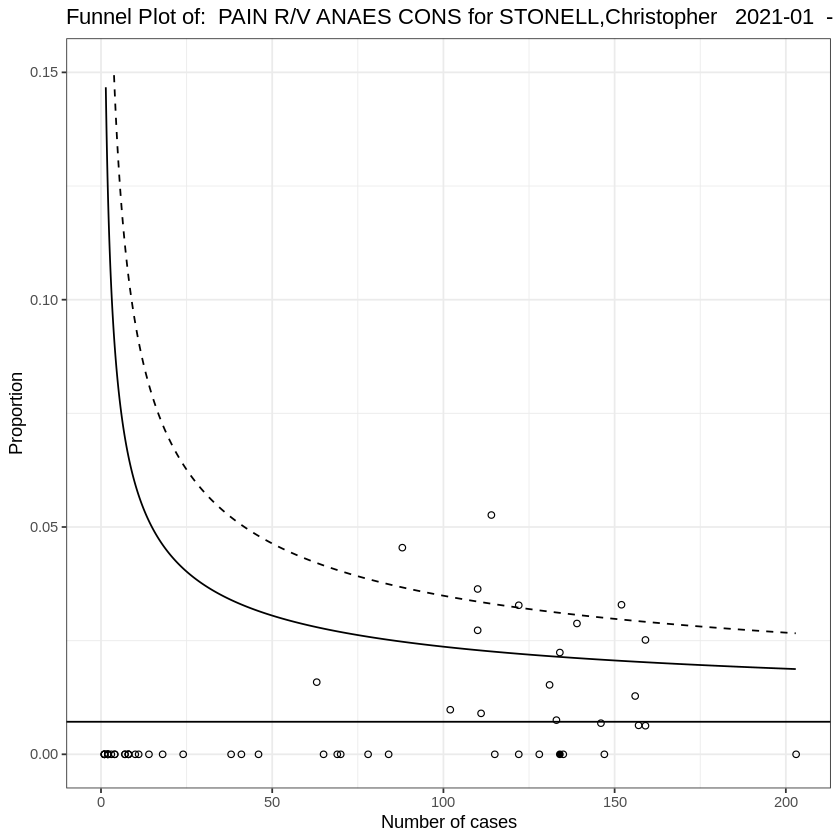

In [8]:
# FUNNEL PLOTS
# Combine mot.data & pacu.data into one data set linked by MRN & date
combined.data <- join(mot.data, pacu.data, by=c("MRN","date"), type='right', match='all')
# Clean up combined.data - remove cases with no anaesthetist, registrars and other extraneous names
registrars <- c("", "ALVAREZ,Juan Sebastian Lopera","BACAJEWSK,Rafal","HUNG,David -  Registrar Anaesthetist","JONES,Alison","POLLARD,Amy","SMITH,Robert","COLLARD,Cameron - Anaes Regs", "LOPERA ALVAREZ,Juan Sebastian", "MEHMOOD,Junaid", "MCDERMOTT,Laura", "JONES,Tyson", "BELL,Cameron - Anaes Regs", "BURNELL,Sheena", "SHAW,Rebecca", "BEUTH,Jodie", "BURGESS,Tegan", "GUY,Louis", "LIM,Kian - Anaes Registrar", "PEARSON,Yana", "RANCE,Timothy","SOUNESS,Andrew", "WILLIAMS,Charles", "DAWAR,Ahmad", "CHAWLA,Gunjan", "HAENKE,Daniel","HUANG,Jason - Gastroenterologist", "RICKARDS,Leah", "TOGNOLINI,Angela", "WILLIAMS,Courtney", "EDWARDS,Lucas", "FERNANDEZ,Nevin", "HOLLAND,Tom", "KIPPIN,Louisa", "TURNER,Maryann", "JAMSHIDI,Behruz", "HUANG,Jason", "DASILVA,Dianna", "FARZADI,Maryam Zarhra", "FLINT,Nathan", "HERDY,Charles", "HOLGATE,Andrew",
                "GYNTHER,Alice","HOLMES,Tiffany","HWANG,Yena - Anaes Registrar","MORTON,Fraser","NEWINGTON,Dasha","OBED,Alvin","PIETZSCH,Anna","TAYLOR,Jessica","TOON,Michael","BEASLEY,Alicia","SINGH,Racquel", "WEIR,Rachael")
combined.data <- combined.data[!combined.data$Anaes.1.Name %in% c(registrars, "MURRAY,John", "POSTLE,David", "BRUNELLO,Kathryn"),]

# remove cases destined to ICU - analyse PACU only
combined.data <- combined.data[combined.data$PACU.ICU.WARD == "PACU",]

events.to.chart <- c(names(events.adverse)[8],names(events.adverse)[10], names(events.adverse)[20])

# manually select adverse events from the list below for now - change to loop once established.
for (event in events.to.chart) {
# determine the anaesthetists names with patients experiencing events
if (event == names(events.adverse)[10]) {cases <- na.omit(combined.data[combined.data$Answer %in% c("ANTIEMETICS","PERSISTENT PONV"),]["Anaes.1.Name"])}
if (event == names(events.adverse)[20]) {cases <- na.omit(combined.data[combined.data$Answer %in% c("PAIN R/V ANAES CONS", "ANAESTH R/V- PAIN"),]["Anaes.1.Name"])}
if (event == names(events.adverse)[8]) {cases <- na.omit(combined.data[combined.data$Answer == "HYPOTHERMIA <36 DEG",]["Anaes.1.Name"])}

# Calculate the case load per anaesthetist - taken from MOT data because row number increased by join to form combined.data
anaes.cases <- NA
p <- NA 
anaes.names <- colnames(table(mot.data$Month_Yr, droplevels(mot.data$Anaes.1.Name, c(registrars, "MURRAY,John", "POSTLE,David", "BRUNELLO,Kathryn"))))
for (i in 1 : length(anaes.names)){
  anaes.cases[i] <- sum(table(mot.data$Month_Yr, droplevels(mot.data$Anaes.1.Name, c(registrars, "MURRAY,John", "POSTLE,David", "BRUNELLO,Kathryn")))[,i])
  p[i] <- sum(cases$Anaes.1.Name == anaes.names[i]) / anaes.cases[i]
  }

## code to plot funnel plot from https://stats.stackexchange.com/questions/5195/how-to-draw-funnel-plot-using-ggplot2-in-r/5210#5210
library(ggplot2)

number <- anaes.cases
p.se <- sqrt((p*(1-p)) / (number))
df <- data.frame(p, number, p.se)

## common effect (fixed effect model)
## p.fem <- weighted.mean(p, 1/p.se^2)
## arithmetic mean - I don't understand the use if FEM and weighted mean - perhaps I should look this up? I have repaced with arithmetic mean
## p.fem <- sum(p*number)/sum(number)
p.fem <- mean(p)

## lower and upper limits for 95% and 99.9% CI, based on FEM estimator
number.seq <- seq(0.001, max(number), 0.1)
number.ll95 <- p.fem - 1.96 * sqrt((p.fem*(1-p.fem)) / (number.seq)) 
number.ul95 <- p.fem + 1.96 * sqrt((p.fem*(1-p.fem)) / (number.seq)) 
number.ll999 <- p.fem - 3.29 * sqrt((p.fem*(1-p.fem)) / (number.seq)) 
number.ul999 <- p.fem + 3.29 * sqrt((p.fem*(1-p.fem)) / (number.seq)) 
dfCI <- data.frame(number.ll95, number.ul95, number.ll999, number.ul999, number.seq, p.fem)

# Only do plots for me for demonstration purposes
anaes.names = "STONELL,Christopher"
for (i in 1:length(anaes.names)){
## draw plot
funnelplot <- ggplot(aes(x = number, y = p), data = df) +
  geom_point(shape = 1) +
  geom_point(aes(x = number[i], y = p[i]), shape = 16) + 
  geom_line(aes(x = number.seq, y = number.ll95), data = dfCI) +
  geom_line(aes(x = number.seq, y = number.ul95), data = dfCI) +
  geom_line(aes(x = number.seq, y = number.ll999), linetype = "dashed", data = dfCI) +
  geom_line(aes(x = number.seq, y = number.ul999), linetype = "dashed", data = dfCI) +
  geom_hline(aes(yintercept = p.fem), data = dfCI) +
  scale_y_continuous(limits = c(0,0.15)) +
  ggtitle(paste("Funnel Plot of: ", event, "for", anaes.names[i]," ",min(mot.data$Month_Yr)," - ", max(mot.data$Month_Yr))) +
  xlab("Number of cases") + ylab(paste("Proportion")) + theme_bw() 

plot(funnelplot)
} # For i loop
} # For events loop


In [9]:
# Clear Workspace
rm(list=ls())